<center><h1>Ensemble Model</h1></center>

# 1. Import Requirements

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# 2. Load Dataset

In [2]:
# Load the preprocessed training and test datasets
train_data = pd.read_csv('dataset_clean/LinearImput_Feature_Scale_Cap_Clean_Train.csv')
test_data = pd.read_csv('dataset_clean/LinearImput_Feature_Scale_Cap_Clean_Test.csv')

In [3]:
# Separate features and target from the training dataset
X_train = train_data.drop(columns=['target'])
Y_train = train_data['target']
X_test = test_data.drop(columns=['target'])
Y_test = test_data['target']

# 3. Train Model 1

In [4]:
# Train XGBoost with class weights to make it robust on class '1' prediction.
model_1 = XGBClassifier(scale_pos_weight=(1/250), random_state=42, n_estimators=300)  # Adjust the weight ratio based on imbalance
model_1.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Model 1 Accuracy: 91.52%

Confusion Matrix:
[[237020     14]
 [ 22183   2495]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.96    237034
           1       0.99      0.10      0.18     24678

    accuracy                           0.92    261712
   macro avg       0.95      0.55      0.57    261712
weighted avg       0.92      0.92      0.88    261712



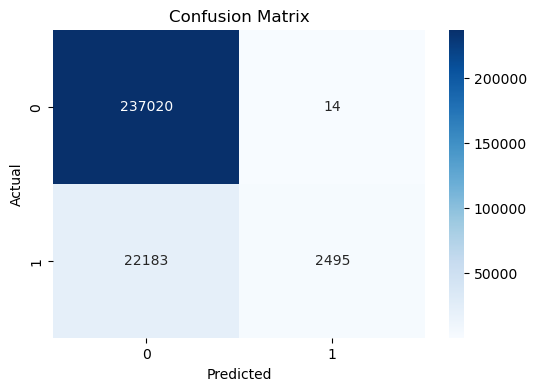

Precision: 0.99
Recall: 0.10
F1-Score: 0.18
ROC-AUC: 0.55


In [9]:
# Make predictions
Y_pred_1 = model_1.predict(X_test)

# Evaluate the model
accuracy_1 = accuracy_score(Y_test, Y_pred_1)
print(f"Model 1 Accuracy: {accuracy_1 * 100:.2f}%")

# Confusion matrix
cm_1 = confusion_matrix(Y_test, Y_pred_1)
print("\nConfusion Matrix:")
print(cm_1)

# Classification report for more detailed evaluation
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred_1))

# Visualizing the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_1, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Precision, Recall, F1-Score
precision_1 = precision_score(Y_test, Y_pred_1)
recall_1 = recall_score(Y_test, Y_pred_1)
f1_1 = f1_score(Y_test, Y_pred_1)
roc_auc_1 = roc_auc_score(Y_test, Y_pred_1)

print(f"Precision: {precision_1:.2f}")
print(f"Recall: {recall_1:.2f}")
print(f"F1-Score: {f1_1:.2f}")
print(f"ROC-AUC: {roc_auc_1:.2f}")

# 4. Train Model 2

In [68]:
model_2 = Sequential()

# Input layer
model_2.add(Input(shape=(X_train.shape[1],)))

model_2.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model_2.add(Dropout(0.4))

model_2.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model_2.add(Dropout(0.4))  # Regularization

model_2.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.4))

model_2.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))

# Output layer
model_2.add(Dense(1, activation='sigmoid'))

# Compile model
optimizer = Adam(learning_rate=0.001)
model_2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

In [69]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(Y_train), y=Y_train)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 0.5520552664885389, 1: 5.302588035065444}


In [79]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='tf_log/model_nn_robust_class_0', histogram_freq=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

model_2.fit(X_train, Y_train, 
          epochs=15, 
          batch_size=128, 
          validation_data=(X_test, Y_test), 
          callbacks=[tensorboard_callback, lr_scheduler],
          class_weight=class_weights
         )

Epoch 1/15
6134/6134 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - AUC: 0.9917 - Precision: 0.7381 - Recall: 0.9983 - accuracy: 0.9663 - loss: 0.0743 - val_AUC: 0.9925 - val_Precision: 0.7388 - val_Recall: 0.9996 - val_accuracy: 0.9666 - val_loss: 0.0997 - learning_rate: 1.2500e-04
Epoch 2/15
6134/6134 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - AUC: 0.9916 - Precision: 0.7363 - Recall: 0.9983 - accuracy: 0.9663 - loss: 0.0744 - val_AUC: 0.9925 - val_Precision: 0.7373 - val_Recall: 0.9996 - val_accuracy: 0.9664 - val_loss: 0.0993 - learning_rate: 1.2500e-04
Epoch 3/15
6134/6134 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - AUC: 0.9917 - Precision: 0.7403 - Recall: 0.9982 - accuracy: 0.9667 - loss: 0.0738 - val_AUC: 0.9923 - val_Precision: 0.7381 - val_Recall: 0.9998 - val_accuracy: 0.9665 - val_loss: 0.1043 - learning_rate: 1.2500e-04
Epoch 4/15
6134/6134 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - AUC: 0.9918 - Precision: 0.7404 - Recall: 0.9983 - accuracy: 0.9669 - loss: 0.0732 - val_AUC: 0.9924 - val_Precision: 0.7426

In [80]:
model_2.save('tf_models/model_nn_robust_class_0.keras')
model_2.save('tf_models/model_nn_robust_class_0.h5')

### Load the Model, if already trained and saved

In [81]:
model_2 = tf.keras.models.load_model('tf_models/model_nn_robust_class_0.keras')

In [82]:
Y_pred_prob_2 = model_2.predict(X_test)

8179/8179 ━━━━━━━━━━━━━━━━━━━━ 7s 839us/step


In [88]:
Y_pred_2 = (Y_pred_prob_2 > 0.4).astype(int).flatten()

Accuracy: 96.64%

Confusion Matrix:
[[228253   8781]
 [     6  24672]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    237034
           1       0.74      1.00      0.85     24678

    accuracy                           0.97    261712
   macro avg       0.87      0.98      0.91    261712
weighted avg       0.98      0.97      0.97    261712



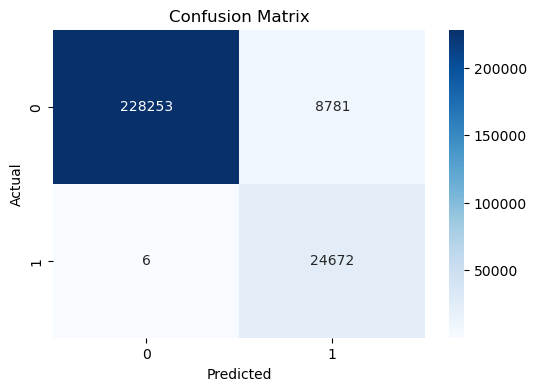

Precision: 0.85
Recall: 0.94
F1-Score: 0.89
ROC-AUC: 0.96


In [89]:
# Evaluate the model
accuracy_2 = accuracy_score(Y_test, Y_pred_2)
print(f"Accuracy: {accuracy_2 * 100:.2f}%")

# Confusion matrix
cm_2 = confusion_matrix(Y_test, Y_pred_2)
print("\nConfusion Matrix:")
print(cm_2)

# Classification report
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred_2))

# Visualizing the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_2, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Precision, Recall, F1-Score
precision_2 = precision_score(Y_test, Y_pred_2)
recall_2 = recall_score(Y_test, Y_pred_2)
f1_2 = f1_score(Y_test, Y_pred_2)
roc_auc_2 = roc_auc_score(Y_test, Y_pred_2)

print(f"Precision: {precision_2:.2f}")
print(f"Recall: {recall_2:.2f}")
print(f"F1-Score: {f1_2:.2f}")
print(f"ROC-AUC: {roc_auc_2:.2f}")

# 5. Extract Probabilities from Model 1 and Model 2

In [90]:
preds_1_train = model_1.predict_proba(X_train)[:, 1] # Predicted probabilities for class 1
preds_2_train = model_2.predict(X_train)
 
# Stack predictions
preds_train = np.column_stack((preds_2_train, preds_1_train))

24536/24536 ━━━━━━━━━━━━━━━━━━━━ 21s 849us/step


In [91]:
pred_1_test = model_1.predict_proba(X_test)[:, 1]
pred_2_test = model_2.predict(X_test)

preds_test = np.column_stack((pred_2_test, pred_1_test))

8179/8179 ━━━━━━━━━━━━━━━━━━━━ 6s 787us/step


In [92]:
print(preds_train.shape)
print(preds_test.shape)

(785133, 2)
(261712, 2)


# 6. Train Meta Model

In [95]:
# Define the model
model_meta = Sequential()

model_meta.add(Input(shape=(preds_train.shape[1],)))

model_meta.add(Dense(8, activation='relu'))

model_meta.add(Dense(4, activation='relu'))

model_meta.add(Dense(1, activation='sigmoid'))

# Compile the model
model_meta.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# Summary of the model
model_meta.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65 (260.00 B)

 Trainable params: 65 (260.00 B)

 Non-trainable params: 0 (0.00 B)

In [96]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

model_meta.fit(preds_train, Y_train, 
          epochs=15, 
          batch_size=128, 
          validation_data=(preds_test, Y_test), 
          callbacks=[lr_scheduler]
         )

Epoch 1/15
6134/6134 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - AUC: 0.9890 - Precision: 0.7745 - Recall: 0.9663 - accuracy: 0.9698 - loss: 0.1419 - val_AUC: 0.9944 - val_Precision: 0.8483 - val_Recall: 0.9225 - val_accuracy: 0.9771 - val_loss: 0.0525 - learning_rate: 0.0010
Epoch 2/15
6134/6134 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - AUC: 0.9948 - Precision: 0.8451 - Recall: 0.9234 - accuracy: 0.9768 - loss: 0.0501 - val_AUC: 0.9945 - val_Precision: 0.8459 - val_Recall: 0.9291 - val_accuracy: 0.9774 - val_loss: 0.0521 - learning_rate: 0.0010
Epoch 3/15
6134/6134 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - AUC: 0.9950 - Precision: 0.8525 - Recall: 0.9174 - accuracy: 0.9773 - loss: 0.0487 - val_AUC: 0.9946 - val_Precision: 0.8439 - val_Recall: 0.9352 - val_accuracy: 0.9776 - val_loss: 0.0521 - learning_rate: 0.0010
Epoch 4/15
6134/6134 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - AUC: 0.9952 - Precision: 0.8570 - Recall: 0.9167 - accuracy: 0.9777 - loss: 0.0483 - val_AUC: 0.9946 - val_Precision: 0.8474 - val_Recall: 

In [97]:
# Make predictions on the test set
Y_pred_prob = model_meta.predict(preds_test)

8179/8179 ━━━━━━━━━━━━━━━━━━━━ 7s 808us/step


In [114]:
Y_pred = (Y_pred_prob > 0.475).astype(int).flatten()

Accuracy: 97.82%

Confusion Matrix:
[[232905   4129]
 [  1575  23103]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    237034
           1       0.85      0.94      0.89     24678

    accuracy                           0.98    261712
   macro avg       0.92      0.96      0.94    261712
weighted avg       0.98      0.98      0.98    261712



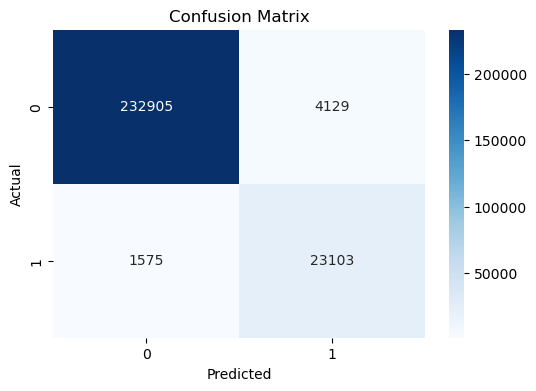

Precision: 0.85
Recall: 0.94
F1-Score: 0.89
ROC-AUC: 0.96


In [115]:
# Evaluate the model
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
print("\nConfusion Matrix:")
print(cm)

# Classification report
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred))

# Visualizing the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Precision, Recall, F1-Score
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
roc_auc = roc_auc_score(Y_test, Y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")

# 7. Train Meta Model - XGB (optional)
For validation

In [93]:
# Train a meta-model on the stacked predictions
meta_model_xgb = XGBClassifier(random_state=42, n_estimators=100)
meta_model_xgb.fit(preds_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Weighted XGB Accuracy: 97.80%

Confusion Matrix:
[[233047   3987]
 [  1767  22911]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    237034
           1       0.85      0.93      0.89     24678

    accuracy                           0.98    261712
   macro avg       0.92      0.96      0.94    261712
weighted avg       0.98      0.98      0.98    261712



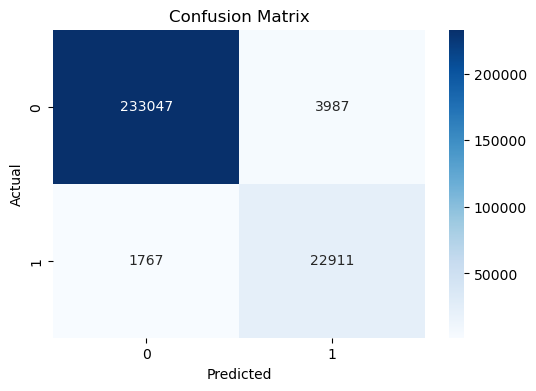

Precision: 0.85
Recall: 0.93
F1-Score: 0.89
ROC-AUC: 0.96


In [94]:
# Final prediction using the meta-model
Y_pred_meta = meta_model_xgb.predict(preds_test)

# Evaluate the model
accuracy_meta = accuracy_score(Y_test, Y_pred_meta)
print(f"Weighted XGB Accuracy: {accuracy_meta * 100:.2f}%")

# Confusion matrix
cm_meta = confusion_matrix(Y_test, Y_pred_meta)
print("\nConfusion Matrix:")
print(cm_meta)

# Classification report for more detailed evaluation
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred_meta))

# Visualizing the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_meta, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Precision, Recall, F1-Score
precision_meta = precision_score(Y_test, Y_pred_meta)
recall_meta = recall_score(Y_test, Y_pred_meta)
f1_meta = f1_score(Y_test, Y_pred_meta)
roc_auc_meta = roc_auc_score(Y_test, Y_pred_meta)

print(f"Precision: {precision_meta:.2f}")
print(f"Recall: {recall_meta:.2f}")
print(f"F1-Score: {f1_meta:.2f}")
print(f"ROC-AUC: {roc_auc_meta:.2f}")

In [ ]:
# Here Neural Network Meta Model performs better than the XGB Meta Model